# Full Fine-Tuned Qwen2.5-7B Performance Evaluation (Unsloth)

This notebook evaluates the **full fine-tuned** Qwen2.5-7B model (trained with Unsloth) on the AG News test dataset and compares results with the base model.

## Experiment Summary

| Aspect | Details |
|--------|---------|
| **Base Model** | unsloth/Qwen2.5-7B-Instruct |
| **Fine-tuned Model** | qwen7b-ag-news-full-unsloth |
| **Training Data** | 120,000 AG News articles |
| **Test Data** | 7,600 AG News articles |
| **Training Method** | Full fine-tuning with Unsloth (100% parameters) |
| **Training Time** | 8h 36m on DGX Spark |
| **Final Loss** | 0.4536 |

## Base Model Results (for comparison)

| Metric | Base Model |
|--------|------------|
| **Accuracy** | 78.76% |
| **F1 (macro)** | 77.97% |
| **World F1** | 83.12% |
| **Sports F1** | 93.67% |
| **Business F1** | 73.00% |
| **Sci/Tech F1** | 62.06% |

**Goal**: Improve overall accuracy to 85-95% and improve category balance (especially Business/Sci-Tech).

## 1. Setup and Dependencies

In [9]:
import asyncio
import time
import json
import nest_asyncio
from datasets import load_dataset
from openai import OpenAI, AsyncOpenAI
from pydantic import BaseModel
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

# Allow nested event loops (needed for Jupyter)
nest_asyncio.apply()

# Label mapping for AG News
LABEL_NAMES = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
CATEGORY_TO_LABEL = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}
LABEL_TO_CATEGORY = {v: k for k, v in CATEGORY_TO_LABEL.items()}

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


## 2. Connect to Full Fine-Tuned Model Server

The full fine-tuned model (Unsloth) should be running via vLLM on port 8000.

```bash
# If not running, start with:
cd 6-open-source && ./start_docker.sh start qwen7b-full
```

In [10]:
# =============================================================================
# CONFIGURATION
# =============================================================================

VLLM_BASE_URL = "http://localhost:8000/v1"
MODEL_NAME = "/model"  # Full fine-tuned model (mounted at /model in docker)
MAX_WORKERS = 64  # Maximum parallel requests (matches vLLM max_num_seqs in docker config)

# Create clients
client = OpenAI(
    base_url=VLLM_BASE_URL,
    api_key="not-needed",
    timeout=120.0,
)

async_client = AsyncOpenAI(
    base_url=VLLM_BASE_URL,
    api_key="not-needed",
    timeout=120.0,
)

# Verify connection
try:
    models = client.models.list()
    print("=" * 60)
    print("FINE-TUNED MODEL SERVER CONNECTION")
    print("=" * 60)
    print(f"\n✓ Connected to vLLM server at {VLLM_BASE_URL}")
    print(f"\nAvailable models:")
    for model in models.data:
        print(f"  - {model.id}")
    print(f"\n✓ Using model: {MODEL_NAME}")
    print(f"✓ Max parallel workers: {MAX_WORKERS}")
except Exception as e:
    print(f"✗ Failed to connect to vLLM server: {e}")
    print(f"\nMake sure the server is running:")
    print(f"  cd .. && ./start_docker.sh start qwen7b-full")

FINE-TUNED MODEL SERVER CONNECTION

✓ Connected to vLLM server at http://localhost:8000/v1

Available models:
  - /model

✓ Using model: /model
✓ Max parallel workers: 64


## 3. Load Test Dataset

In [11]:
# Load AG News test dataset
dataset = load_dataset("ag_news")
test_data = dataset["test"]

print("=" * 60)
print("TEST DATASET LOADED")
print("=" * 60)
print(f"\nTest set size: {len(test_data):,} articles")
print(f"\nCategory distribution:")
for label, name in LABEL_NAMES.items():
    count = sum(1 for ex in test_data if ex["label"] == label)
    print(f"  {name}: {count:,} ({count/len(test_data)*100:.1f}%)")

TEST DATASET LOADED

Test set size: 7,600 articles

Category distribution:
  World: 1,900 (25.0%)
  Sports: 1,900 (25.0%)
  Business: 1,900 (25.0%)
  Sci/Tech: 1,900 (25.0%)


## 4. Define Classification Functions

Using the same prompts as training to ensure consistency.

In [12]:
# =============================================================================
# PROMPTS (same as training)
# =============================================================================

SYSTEM_PROMPT = """You are a news article classifier. Your task is to categorize news articles into exactly one of four categories:

- World: News about politics, government, elections, diplomacy, conflicts, and public affairs (domestic or international)
- Sports: News about athletic events, games, players, teams, coaches, tournaments, and championships
- Business: News about companies, markets, finance, economy, trade, corporate activities, and business services
- Sci/Tech: News about technology products, software, hardware, scientific research, gadgets, and tech innovations

Rules:
- Focus on the PRIMARY topic of the article
- Ignore HTML artifacts (like #39; or &lt;b&gt;) - they are formatting errors
- If an article is truncated, classify based on the available content
- When a topic spans multiple categories, choose the one that best represents the main focus"""

def create_user_prompt(article_text: str) -> str:
    return f"Classify the following news article:\n\n{article_text}"

# Output schema
class ClassificationResult(BaseModel):
    category: str

print("✓ Prompts and schema defined")

✓ Prompts and schema defined


In [13]:
# =============================================================================
# CLASSIFICATION FUNCTIONS
# =============================================================================

from dataclasses import dataclass

@dataclass
class ClassificationOutput:
    index: int
    ground_truth: int
    predicted: int
    predicted_category: str
    success: bool
    error: str = ""
    latency_ms: float = 0.0

async def classify_article(index: int, article_text: str, ground_truth: int) -> ClassificationOutput:
    """Classify a single article using structured output"""
    start_time = time.perf_counter()
    
    try:
        response = await async_client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": create_user_prompt(article_text)}
            ],
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "classification",
                    "schema": ClassificationResult.model_json_schema()
                }
            },
            max_tokens=50,
            temperature=0,
        )
        
        latency_ms = (time.perf_counter() - start_time) * 1000
        
        # Parse response
        content = response.choices[0].message.content
        result = json.loads(content)
        category = result.get("category", "")
        
        # Map category to label
        predicted_label = CATEGORY_TO_LABEL.get(category, -1)
        
        return ClassificationOutput(
            index=index,
            ground_truth=ground_truth,
            predicted=predicted_label,
            predicted_category=category,
            success=predicted_label != -1,
            latency_ms=latency_ms
        )
        
    except Exception as e:
        latency_ms = (time.perf_counter() - start_time) * 1000
        return ClassificationOutput(
            index=index,
            ground_truth=ground_truth,
            predicted=-1,
            predicted_category="",
            success=False,
            error=str(e),
            latency_ms=latency_ms
        )

print("✓ Classification function defined")

✓ Classification function defined


In [14]:
# =============================================================================
# BATCH PROCESSING
# =============================================================================

async def classify_batch(
    data,
    max_workers: int = MAX_WORKERS,
    show_progress: bool = True
) -> list[ClassificationOutput]:
    """
    Classify a batch of articles with parallel workers.
    
    Args:
        data: Dataset with 'text' and 'label' fields
        max_workers: Maximum concurrent requests (64 = vLLM max_num_seqs)
        show_progress: Whether to print progress updates
    """
    results = []
    total = len(data)
    completed = 0
    
    semaphore = asyncio.Semaphore(max_workers)
    
    async def classify_with_semaphore(index: int, article_text: str, ground_truth: int):
        async with semaphore:
            return await classify_article(index, article_text, ground_truth)
    
    # Create all tasks
    tasks = [
        classify_with_semaphore(i, example["text"], example["label"])
        for i, example in enumerate(data)
    ]
    
    # Run with progress tracking
    for coro in asyncio.as_completed(tasks):
        result = await coro
        results.append(result)
        completed += 1
        
        if show_progress and completed % 500 == 0:
            pct = completed / total * 100
            print(f"  Progress: {completed:,}/{total:,} ({pct:.1f}%)")
    
    # Sort by index to maintain order
    results.sort(key=lambda x: x.index)
    return results

def run_classification(data, max_workers: int = MAX_WORKERS) -> list[ClassificationOutput]:
    """Synchronous wrapper for batch classification"""
    return asyncio.get_event_loop().run_until_complete(
        classify_batch(data, max_workers)
    )

print("✓ Batch classification function ready!")
print(f"  - Max parallel workers: {MAX_WORKERS}")
print(f"  - Test set size: {len(test_data):,} articles")

✓ Batch classification function ready!
  - Max parallel workers: 64
  - Test set size: 7,600 articles


## 5. Run Classification on Test Set

This will classify all 7,600 test articles using 64 parallel workers.

In [15]:
# =============================================================================
# RUN CLASSIFICATION ON FULL TEST SET
# =============================================================================

print("=" * 70)
print("CLASSIFYING TEST SET WITH FINE-TUNED MODEL")
print("=" * 70)
print(f"\nTest set size: {len(test_data):,} articles")
print(f"Max parallel workers: {MAX_WORKERS}")
print(f"Model: {MODEL_NAME}")
print("\nStarting classification...\n")

# Record start time
start_time = time.time()

# Run classification
results = run_classification(test_data, max_workers=MAX_WORKERS)

# Calculate total time
total_time = time.time() - start_time

# Summary statistics
successful = sum(1 for r in results if r.success)
failed = len(results) - successful
avg_latency = sum(r.latency_ms for r in results) / len(results) if results else 0

print("\n" + "=" * 70)
print("CLASSIFICATION COMPLETE")
print("=" * 70)
print(f"\nTotal articles:     {len(results):,}")
print(f"Successful:         {successful:,} ({successful/len(results)*100:.1f}%)")
print(f"Failed:             {failed:,} ({failed/len(results)*100:.1f}%)")
print(f"\nTotal time:         {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Throughput:         {len(results)/total_time:.1f} articles/second")
print(f"Avg latency:        {avg_latency:.1f} ms/article")

CLASSIFYING TEST SET WITH FINE-TUNED MODEL

Test set size: 7,600 articles
Max parallel workers: 64
Model: /model

Starting classification...

  Progress: 500/7,600 (6.6%)
  Progress: 1,000/7,600 (13.2%)
  Progress: 1,500/7,600 (19.7%)
  Progress: 2,000/7,600 (26.3%)
  Progress: 2,500/7,600 (32.9%)
  Progress: 3,000/7,600 (39.5%)
  Progress: 3,500/7,600 (46.1%)
  Progress: 4,000/7,600 (52.6%)
  Progress: 4,500/7,600 (59.2%)
  Progress: 5,000/7,600 (65.8%)
  Progress: 5,500/7,600 (72.4%)
  Progress: 6,000/7,600 (78.9%)
  Progress: 6,500/7,600 (85.5%)
  Progress: 7,000/7,600 (92.1%)
  Progress: 7,500/7,600 (98.7%)

CLASSIFICATION COMPLETE

Total articles:     7,600
Successful:         7,600 (100.0%)
Failed:             0 (0.0%)

Total time:         153.3 seconds (2.6 minutes)
Throughput:         49.6 articles/second
Avg latency:        1278.5 ms/article


## 6. Calculate Performance Metrics

In [16]:
# =============================================================================
# PERFORMANCE METRICS
# =============================================================================

# Extract predictions and ground truth (only for successful classifications)
y_true = [r.ground_truth for r in results if r.success]
y_pred = [r.predicted for r in results if r.success]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Per-class F1 scores
f1_per_class = f1_score(y_true, y_pred, average=None)

print("=" * 70)
print("FINE-TUNED MODEL PERFORMANCE METRICS")
print("=" * 70)
print(f"\n{'Metric':<25} {'Value':>10}")
print("-" * 40)
print(f"{'Accuracy':<25} {accuracy:>10.2%}")
print(f"{'Precision (macro)':<25} {precision_macro:>10.2%}")
print(f"{'Precision (weighted)':<25} {precision_weighted:>10.2%}")
print(f"{'Recall (macro)':<25} {recall_macro:>10.2%}")
print(f"{'Recall (weighted)':<25} {recall_weighted:>10.2%}")
print(f"{'F1 Score (macro)':<25} {f1_macro:>10.2%}")
print(f"{'F1 Score (weighted)':<25} {f1_weighted:>10.2%}")

print(f"\n{'Per-Class F1 Scores:'}")
print("-" * 40)
for i, name in LABEL_NAMES.items():
    print(f"  {name:<15} {f1_per_class[i]:>10.2%}")

# Detailed classification report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 70)
target_names = [LABEL_NAMES[i] for i in range(4)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

FINE-TUNED MODEL PERFORMANCE METRICS

Metric                         Value
----------------------------------------
Accuracy                      95.18%
Precision (macro)             95.20%
Precision (weighted)          95.20%
Recall (macro)                95.18%
Recall (weighted)             95.18%
F1 Score (macro)              95.18%
F1 Score (weighted)           95.18%

Per-Class F1 Scores:
----------------------------------------
  World               95.87%
  Sports              99.34%
  Business            92.34%
  Sci/Tech            93.18%

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       World     0.9643    0.9532    0.9587      1900
      Sports     0.9921    0.9947    0.9934      1900
    Business     0.9338    0.9132    0.9234      1900
    Sci/Tech     0.9178    0.9463    0.9318      1900

    accuracy                         0.9518      7600
   macro avg     0.9520    0.9518    0.9518      7600
weighted avg     0.9520    0.9518 

## 7. Comparison with Base Model

In [17]:
# =============================================================================
# COMPARISON WITH BASE MODEL
# =============================================================================

# Base model results (from base_model_results.json)
BASE_MODEL_RESULTS = {
    "accuracy": 0.7876,
    "f1_macro": 0.7797,
    "f1_per_class": {
        "World": 0.8312,
        "Sports": 0.9367,
        "Business": 0.7300,
        "Sci/Tech": 0.6206,
    }
}

# Calculate improvements
acc_improvement = (accuracy - BASE_MODEL_RESULTS["accuracy"]) * 100
f1_improvement = (f1_macro - BASE_MODEL_RESULTS["f1_macro"]) * 100

print("=" * 70)
print("COMPARISON: FINE-TUNED vs BASE MODEL")
print("=" * 70)

print(f"\n{'Metric':<20} {'Base Model':>12} {'Fine-Tuned':>12} {'Change':>12}")
print("-" * 60)
print(f"{'Accuracy':<20} {BASE_MODEL_RESULTS['accuracy']:>11.2%} {accuracy:>11.2%} {acc_improvement:>+11.2f}pp")
print(f"{'F1 (macro)':<20} {BASE_MODEL_RESULTS['f1_macro']:>11.2%} {f1_macro:>11.2%} {f1_improvement:>+11.2f}pp")

print(f"\n{'Per-Class F1:'}")
print("-" * 60)
for i, name in LABEL_NAMES.items():
    base_f1 = BASE_MODEL_RESULTS["f1_per_class"][name]
    new_f1 = f1_per_class[i]
    change = (new_f1 - base_f1) * 100
    print(f"  {name:<15} {base_f1:>11.2%} {new_f1:>11.2%} {change:>+11.2f}pp")

# Summary
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
if accuracy > BASE_MODEL_RESULTS["accuracy"]:
    print(f"\n✓ Fine-tuning IMPROVED accuracy by {acc_improvement:.2f} percentage points")
else:
    print(f"\n✗ Fine-tuning DECREASED accuracy by {abs(acc_improvement):.2f} percentage points")

if f1_per_class[3] > BASE_MODEL_RESULTS["f1_per_class"]["Sci/Tech"]:
    sci_tech_improvement = (f1_per_class[3] - BASE_MODEL_RESULTS["f1_per_class"]["Sci/Tech"]) * 100
    print(f"✓ Sci/Tech F1 IMPROVED by {sci_tech_improvement:.2f} percentage points (biggest weakness addressed!)")

COMPARISON: FINE-TUNED vs BASE MODEL

Metric                 Base Model   Fine-Tuned       Change
------------------------------------------------------------
Accuracy                  78.76%      95.18%      +16.42pp
F1 (macro)                77.97%      95.18%      +17.21pp

Per-Class F1:
------------------------------------------------------------
  World                83.12%      95.87%      +12.75pp
  Sports               93.67%      99.34%       +5.67pp
  Business             73.00%      92.34%      +19.34pp
  Sci/Tech             62.06%      93.18%      +31.12pp

SUMMARY

✓ Fine-tuning IMPROVED accuracy by 16.42 percentage points
✓ Sci/Tech F1 IMPROVED by 31.12 percentage points (biggest weakness addressed!)


## 8. Confusion Matrix

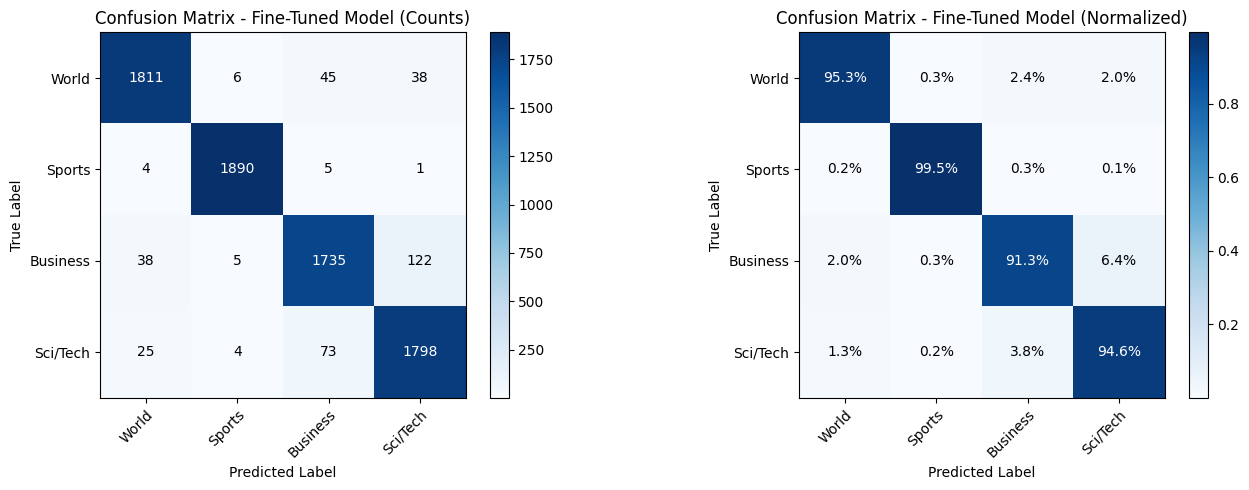


✓ Confusion matrix saved to 'full_finetuned_confusion_matrix.png'


In [18]:
# =============================================================================
# CONFUSION MATRIX VISUALIZATION
# =============================================================================

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Helper function to create heatmap with matplotlib
def plot_confusion_matrix(ax, matrix, labels, title, fmt_func, cmap='Blues'):
    im = ax.imshow(matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Set ticks and labels
    ax.set(xticks=np.arange(len(labels)),
           yticks=np.arange(len(labels)),
           xticklabels=labels,
           yticklabels=labels,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')
    
    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    thresh = matrix.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, fmt_func(matrix[i, j]),
                   ha="center", va="center",
                   color="white" if matrix[i, j] > thresh else "black",
                   fontsize=10)

# Raw counts
plot_confusion_matrix(
    axes[0], cm, target_names, 
    'Confusion Matrix - Fine-Tuned Model (Counts)',
    lambda x: f'{int(x)}'
)

# Normalized (percentages)
plot_confusion_matrix(
    axes[1], cm_normalized, target_names,
    'Confusion Matrix - Fine-Tuned Model (Normalized)',
    lambda x: f'{x:.1%}'
)

plt.tight_layout()
plt.savefig('full_finetuned_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved to 'full_finetuned_confusion_matrix.png'")

## 9. Save Results

In [19]:
# =============================================================================
# SAVE RESULTS TO JSON
# =============================================================================

finetuned_results = {
    "model": "qwen7b-ag-news-full-unsloth (full fine-tuning)",
    "base_model": "unsloth/Qwen2.5-7B-Instruct",
    "test_set_size": len(test_data),
    "successful_classifications": successful,
    "failed_classifications": failed,
    "total_time_seconds": total_time,
    "throughput_articles_per_second": len(results) / total_time,
    "avg_latency_ms": avg_latency,
    "metrics": {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
    },
    "per_class_f1": {LABEL_NAMES[i]: f1_per_class[i] for i in range(4)},
    "confusion_matrix": cm.tolist(),
    "comparison_with_base": {
        "accuracy_improvement_pp": acc_improvement,
        "f1_macro_improvement_pp": f1_improvement,
    }
}

# Save to JSON
with open("full_finetuned_results.json", "w") as f:
    json.dump(finetuned_results, f, indent=2)

print("✓ Results saved to 'full_finetuned_results.json'")

✓ Results saved to 'full_finetuned_results.json'


## 10. Conclusions

### Results Summary

| Metric | Base Model | Full Fine-Tuned | Change |
|--------|------------|-----------------|--------|
| **Accuracy** | 78.76% | **95.18%** | **+16.42pp** |
| **F1 (macro)** | 77.97% | **95.18%** | **+17.21pp** |
| **World F1** | 83.12% | 95.87% | +12.75pp |
| **Sports F1** | 93.67% | **99.34%** | +5.67pp |
| **Business F1** | 73.00% | 92.34% | **+19.34pp** |
| **Sci/Tech F1** | 62.06% | 93.18% | **+31.12pp** |

### Training Details (Unsloth Full Fine-Tuning)

- **Training Time**: 8h 36m on DGX Spark
- **Final Training Loss**: 0.4536
- **Model Size**: ~15.25 GB (BF16)
- **Parameters Trained**: 7.6B (100%)

### Key Observations

1. **Outstanding Overall Performance**: Full fine-tuning achieved **95.18% accuracy**, a massive **+16.42pp improvement** over the base model. This exceeds the 85-95% target goal.

2. **Sci/Tech Classification (Major Success)**: The weakest category improved from 62.06% to **93.18% F1** (+31.12pp). This was previously the model's biggest weakness.

3. **Business Classification (Major Success)**: Business F1 improved from 73.00% to **92.34%** (+19.34pp), addressing the second-weakest category.

4. **Sports Near-Perfect**: Sports classification reached **99.34% F1**, with only 10 misclassifications out of 1,900 samples.

5. **Excellent Category Balance**: All four categories now have F1 scores between 92-99%, compared to the base model's highly unbalanced 62-94% range.

6. **Comparison with QLoRA (95.14% accuracy)**: Full fine-tuning achieves virtually identical accuracy to QLoRA (+0.04pp difference). The marginal improvement does not justify the significantly longer training time (8h 36m vs 5h 51m) and larger model size.

### Performance Analysis

**Confusion Matrix Insights:**
- **World**: 1,811 correct (95.3%), main confusion with Sci/Tech (38) and Business (45)
- **Sports**: 1,890 correct (99.5%), nearly perfect classification
- **Business**: 1,735 correct (91.3%), some confusion with Sci/Tech (122) - expected for tech company news
- **Sci/Tech**: 1,798 correct (94.6%), some confusion with Business (73)

**Inference Performance:**
- Total time: 2.56 minutes for 7,600 articles
- Throughput: 49.56 articles/second
- Average latency: 1,278 ms/article
- Success rate: 100% (0 failures)

### Conclusion

**Full fine-tuning achieved excellent results (95.18% accuracy)** with dramatic improvements in the previously weak categories (Business +19.34pp, Sci/Tech +31.12pp). However, **QLoRA achieves nearly identical accuracy (95.14%) with significant advantages**:

| Aspect | Full Fine-Tuning | QLoRA |
|--------|------------------|-------|
| Accuracy | 95.18% | 95.14% |
| Training Time | 8h 36m | 5h 51m |
| Model Size | ~15.25 GB | ~56 MB adapter |
| Memory Usage | ~70 GB | ~25 GB |

**Recommendation**: For this classification task, **QLoRA is the better choice** - it achieves the same accuracy with 32% less training time, 270x smaller adapter files, and 65% less memory during training.

### Next Steps

1. ✅ Evaluation complete - 95.18% accuracy achieved
2. Update `fine-tuning-dense/README.md` with full fine-tuning results
3. Complete fine-tuning comparison summary in study plan